In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
import matplotlib.pyplot as plt
import torch.nn.functional as F
from glob import glob
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np
import torch
import os
from google.colab import drive
drive.mount('/content/drive')
torch.manual_seed(0)

Mounted at /content/drive


# Defining dataset and loaders

In [ ]:
# Initializing hyperparameters
Img_size = 256
num_epochs = 20
learning_rate = 1e-2
batch_size = 8
pin_memory = True
num_workers = 2
device = "cuda" if torch.cuda.is_available() else "cpu"


def Otsu(img):
    mean = img.mean()
    img[img < mean] = 0
    img[img > mean] = 1
    return img

transforms = T.Compose(
    [T.ToTensor(),
        T.Resize((Img_size, Img_size)),
        T.RandomRotation(20),
     T.RandomErasing(scale=(0.02, 0.1)),
     Otsu
    ])

class Testdata(Dataset):
    def __init__(self, directory, transforms):
        self.files = glob(directory)
        self.transform = transforms
        self.dir = directory
    def __len__(self):
        return len(self.files)
    def __getitem__(self, index):
        file = self.files[index]
        img = Image.open(os.path.join(self.dir, file)).convert('RGB')
        img = self.transform(img)
        return img, file

full_dataset = ImageFolder(r"/content/drive/MyDrive/SCTL-main/SCTL-main/Train", transform = transforms)
test_ds = Testdata(r"/content/drive/MyDrive/SCTL-main/SCTL-main/Test/Test/*.jpg", transforms= transforms)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  pin_memory=pin_memory)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
test_dl = DataLoader(test_ds, batch_size=batch_size, pin_memory=pin_memory)

torch.Size([8, 3, 256, 256])


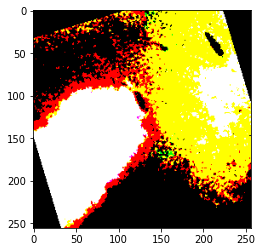

In [ ]:
for img, lbl in train_dl:
    plt.imshow(img[0].swapaxes(0, 2))
    print(img.shape)
    break

[0.6083551  0.5726719  0.83724976 0.98172325]


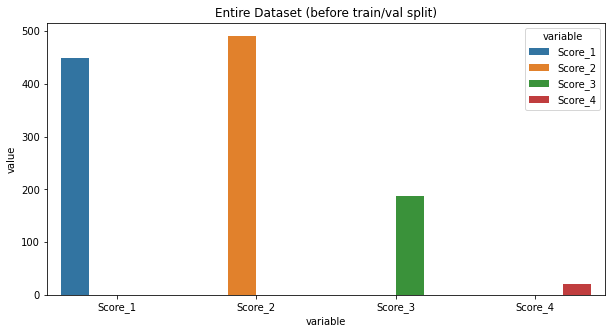

In [ ]:
idx2class = {v: k for k, v in full_dataset.class_to_idx.items()}
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable").set_title(plot_title)
plt.figure(figsize=(10,5))
class_dist = get_class_distribution(full_dataset)
plot_from_dict(class_dist, plot_title="Entire Dataset (before train/val split)")

# Inverse class weights
inverse_cls_dist = 1 - np.array(list(class_dist.values()), dtype=np.float32)/len(full_dataset)
print(inverse_cls_dist)

# 1. Build your own convolutional neural network using pytorch

# VGG 19

In [ ]:
class VGG19(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential( 
            nn.Conv2d(3, 64, 3, padding=1),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(3, stride=1),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(512*3*3, 5000),
            nn.ReLU(),
            nn.Linear(5000, 500),
            nn.ReLU(),
            nn.Linear(500, 4),
     )
    def forward(self, img):
        return self.model(img)
vgg_19 = VGG19().to(device)
for img, lbl in train_dl:
    print(vgg_19(img.to(device)).shape)
    break

torch.Size([8, 4])


# Custom model

In [ ]:
class TeatClassifier(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels = 16, kernel_size = 5, stride=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size = (3, 3), stride=(2, 2)),
            nn.Dropout(0.3),
            nn.LeakyReLU(), 
            nn.Conv2d(in_channels=16, out_channels = 32, kernel_size = 5, stride=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = (3, 3), stride=(2, 2)),
            nn.Dropout(0.3),
            nn.LeakyReLU(), 
            nn.Conv2d(in_channels=32, out_channels = 64, kernel_size = 5, stride=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size = (3, 3), stride=(2, 2)),
            nn.Dropout(0.3),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(64*2*2, 1000), 
            nn.LeakyReLU(),
            nn.Linear(1000, 4)
        )

    def forward(self, x):
        return self.model(x)


teatclf = TeatClassifier().to(device)
teatclf(img.to(device)).shape

torch.Size([8, 4])

# Resnet 18

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out) 
        out = self.bn2(out)
        out += self.shortcut(x) * 3
        out = self.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

resnet18 = ResNet18(num_classes=4).to(device)

resnet18(img.to(device)).shape

torch.Size([8, 4])

# Stacked CNN model and Custom ResNet18

In [ ]:
class Combined_model(nn.Module):
    def __init__(self, modelA, modelB):
        super(Combined_model, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(8, 4)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(F.relu(x))
        return x
stackedm = Combined_model(resnet18, teatclf).to(device)
stackedm(img.to(device)).shape

torch.Size([8, 4])

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, reduction='sum'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.weight is not None:
            focal_loss = focal_loss * self.weight

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

In [11]:
num_epochs = 40
learning_rate = 0.001
clf = stackedm
opt = torch.optim.Adam(clf.parameters(), lr=learning_rate)
loss1 = nn.CrossEntropyLoss(weight=torch.tensor(inverse_cls_dist).to(device)) 
# criterion = nn.NLLLoss()
loss2 = FocalLoss(gamma=2.5) # Focal loss is used to calculate loss when the dataset is imbalanced
training_loss = []
valid_loss = []
valid_acc = []
train_acc = []

the_last_loss = 100
patience = 2
trigger_times = 0

best_accuracy = 0.2
for epoch in range(1, num_epochs+1):
# Training loop
    clf.train(True)
    correct = 0
    for X, y in tqdm(train_dl):  
        X, y = X.to(device), y.to(device) 
        opt.zero_grad()
        yhat = clf(X) 
        loss = (loss1(yhat, y)*0.4) + (loss2(yhat, y)*0.6)
        # Apply backprop 
        loss.backward()
        opt.step() 
        correct += (torch.argmax(yhat, dim=1) == y).float().sum().detach().cpu()
    accuracy = 100 * correct / len(train_dataset)
    train_acc.append(accuracy)    
    training_loss.append(loss.item())
    print(f"Epoch:{epoch} training accuracy is {accuracy}")
    print(f"Epoch:{epoch} training loss is {loss.item()}")
    
    clf.train(False)

    # Valid loop
    correct = 0
    with torch.no_grad():
        for X, y in tqdm(valid_dl): 
            X, y = X.to(device), y.to(device) 
            yhat = clf(X) 
            loss = (loss1(yhat, y)*0.4) + (loss2(yhat, y)*0.6) 
            correct += (torch.argmax(yhat, dim=1) == y).float().sum().detach().cpu()
        accuracy = 100 * correct / len(valid_dataset)
        valid_acc.append(accuracy)
        valid_loss.append(loss.item())    
        print(f"Epoch:{epoch} valid accuracy is {accuracy}") 
        print(f"Epoch:{epoch} valid loss is {loss.item()}")

        if accuracy > best_accuracy:
          best_accuracy = accuracy
          torch.save(clf.state_dict(), f"model_{accuracy}_.pt")
    # Early stopping
    if loss > the_last_loss:
      trigger_times += 1
    if trigger_times > 0 and loss < the_last_loss:
      trigger_times -= 1
    if trigger_times == patience:
      break
    the_last_loss = loss
    print("Trigger: ", trigger_times)
    print("-"*50)
print("Training complete")

100%|██████████| 115/115 [00:58<00:00,  1.97it/s]


Epoch:1 training accuracy is 34.27638626098633
Epoch:1 training loss is 1.7740777730941772


100%|██████████| 29/29 [00:06<00:00,  4.34it/s]


Epoch:1 valid accuracy is 38.260868072509766
Epoch:1 valid loss is 1.4383635520935059
Trigger:  0
--------------------------------------------------


100%|██████████| 115/115 [00:56<00:00,  2.04it/s]


Epoch:2 training accuracy is 36.670291900634766
Epoch:2 training loss is 1.7436972856521606


100%|██████████| 29/29 [00:07<00:00,  4.01it/s]


Epoch:2 valid accuracy is 38.260868072509766
Epoch:2 valid loss is 2.0589332580566406
Trigger:  1
--------------------------------------------------


100%|██████████| 115/115 [00:55<00:00,  2.07it/s]


Epoch:3 training accuracy is 39.281829833984375
Epoch:3 training loss is 2.1028685569763184


100%|██████████| 29/29 [00:06<00:00,  4.22it/s]

Epoch:3 valid accuracy is 38.260868072509766
Epoch:3 valid loss is 2.876051425933838
Training complete


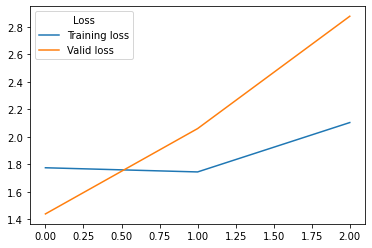

In [12]:
plt.plot(training_loss,label='Training loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend(loc='upper left', title='Loss');

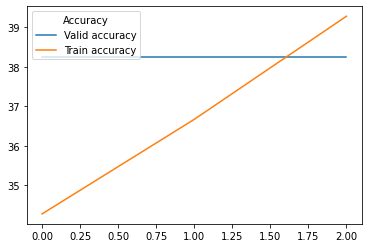

In [13]:
plt.plot(valid_acc, label='Valid accuracy')
plt.plot(train_acc, label='Train accuracy')
plt.legend(loc='upper left', title='Accuracy');

In [14]:
with open('model.pt', 'wb') as f: 
    torch.save(clf.state_dict(), f) 

test_preds = []
files = []

with torch.no_grad():
    
    for batch in test_dl:
        img, fname = batch
        pred = clf(img.to(device))
        test_preds.extend(torch.argmax(pred, dim=1).detach().cpu())
        files.extend(np.array(fname).flatten())

print(len(files))
print(len(test_preds))
df = pd.DataFrame({"Imagename":files, "preds":test_preds})
df.preds = df.preds.astype(int)
df.Imagename = df.Imagename.apply(lambda x: x.split("/")[-1])
df.to_csv("submission.csv", header=None, index=None)
pd.read_csv("submission.csv")

380
380


,20200724_094356_LH_C2_PN_M.jpg,0
0,20200724_094157_LF_C2_PN_M.jpg,0
1,20200724_094108_RF_C1_PN_M.jpg,0
2,20200724_093930_LH_C3_PN_M.jpg,0
3,20200724_094337_RF_C1_PN_M.jpg,0
4,20200724_094337_LH_C1_PN_M.jpg,0
...,...,...
374,R8_0736_45_crop_RF_C4_PN_m.jpg,0
375,R8_0726_35_crop_LH_C2_PN_m.jpg,0
376,R7_0692_48_crop_LH_C2_PN_m.jpg,0
377,R9_0793_57_crop_LH_C2_PP_m.jpg,0


# 3. Evaluate your model using the developed software

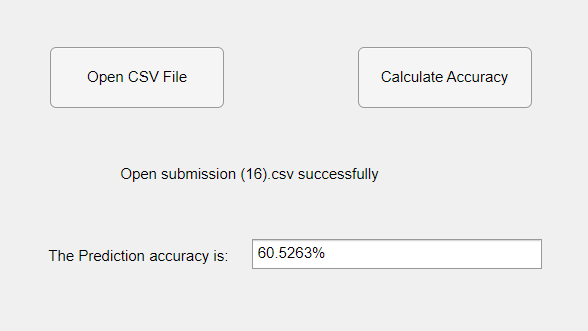

# Paper link
https://www.researchgate.net/publication/369476482_Cow_Teat_Keratosis_level_identification_using_SOTA_Image_algorithms

# Stacking using Meta model

In [15]:
# Train the base models on the training set
model1 = resnet18
model2 = teatclf

model1_loss = []
model2_loss = []

criterion = nn.CrossEntropyLoss(weight=torch.tensor(inverse_cls_dist).to(device)) 
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

num_epochs = 15
for epoch in range(num_epochs):
    # Train model 1
    for imgs, lbls in train_dl:
        optimizer1.zero_grad()
        outputs1 = model1(imgs.to(device))
        loss1 = criterion(outputs1, lbls.to(device))
        loss1.backward()
        optimizer1.step()

        # Train model 2
        optimizer2.zero_grad()
        outputs2 = model2(imgs.to(device))
        loss2 = criterion(outputs2, lbls.to(device))
        loss2.backward()
        optimizer2.step()
    model1_loss.append(loss1.item())
    model2_loss.append(loss2.item())
    print(f"Epoch: {epoch} Resnet loss:", loss1.item())

    print(f" Epoch: {epoch} Custom model loss:", loss2.item())

Epoch: 0 Resnet loss: 1.031126618385315
 Epoch: 0 Custom model loss: 0.9844254851341248
Epoch: 1 Resnet loss: 1.200339436531067
 Epoch: 1 Custom model loss: 1.7105541229248047
Epoch: 2 Resnet loss: 0.6233320832252502
 Epoch: 2 Custom model loss: 0.5108527541160583
Epoch: 3 Resnet loss: 1.5541629791259766
 Epoch: 3 Custom model loss: 1.4060018062591553
Epoch: 4 Resnet loss: 1.1591166257858276
 Epoch: 4 Custom model loss: 0.8741881847381592
Epoch: 5 Resnet loss: 0.7437233924865723
 Epoch: 5 Custom model loss: 0.6142447590827942
Epoch: 6 Resnet loss: 1.379713535308838
 Epoch: 6 Custom model loss: 1.6744904518127441
Epoch: 7 Resnet loss: 0.7874035835266113
 Epoch: 7 Custom model loss: 0.779212474822998
Epoch: 8 Resnet loss: 0.8979591131210327
 Epoch: 8 Custom model loss: 1.0523430109024048
Epoch: 9 Resnet loss: 1.1284207105636597
 Epoch: 9 Custom model loss: 1.6297687292099
Epoch: 10 Resnet loss: 0.7995829582214355
 Epoch: 10 Custom model loss: 0.510192334651947
Epoch: 11 Resnet loss: 0.81

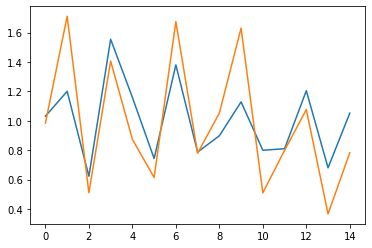

In [16]:
plt.plot(model1_loss)
plt.plot(model2_loss)

In [24]:
# Use the base models to make predictions on the test set
model1_outputs = []
model2_outputs = []
valid_lbls = []
with torch.no_grad():
    for imgs, lbls in valid_dl:
        model1_outputs.extend(model1(imgs.to(device)).flatten())
        model2_outputs.extend(model2(imgs.to(device)).flatten())
        valid_lbls.extend(lbls.to(device).flatten())

valid_lbls = torch.tensor(valid_lbls)
model1_outputs = torch.tensor(model1_outputs).reshape(-1, 4)
model2_outputs = torch.tensor(model2_outputs).reshape(-1, 4)
model1_outputs.shape, model2_outputs.shape, valid_lbls.shape

(torch.Size([230, 4]), torch.Size([230, 4]))

In [25]:
meta_inputs = torch.cat((model1_outputs, model2_outputs), dim=1).to(device)
print(meta_inputs.shape)

torch.Size([230, 8])


In [30]:
# Define the meta model
class MetaModel(nn.Module):
    def __init__(self):
        super(MetaModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(8, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, 4)
        )

    def forward(self, x):
        out = self.model(x)
        return out
# Train the meta model on the concatenated outputs
meta_model = MetaModel().to(device)
optimizer_meta = torch.optim.Adam(meta_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(inverse_cls_dist).to(device)) 
meta_losses = []
num_epochs = 1000
for epoch in range(num_epochs):
    # for imgs, lbls in valid_dl:
    optimizer_meta.zero_grad()
    meta_outputs = meta_model(meta_inputs)
    loss_meta = criterion(meta_outputs, valid_lbls.to(device))
    meta_losses.append(loss_meta.item())
    loss_meta.backward()
    optimizer_meta.step()
    if epoch % 10 == 0:
        print('Meta Loss: %.15f' % loss_meta.item())
print("Meta training done")

Meta Loss: 1.437807440757751
Meta Loss: 1.195867896080017
Meta Loss: 0.950445175170898
Meta Loss: 0.897726714611053
Meta Loss: 0.839654564857483
Meta Loss: 0.771888911724091
Meta Loss: 0.689386546611786
Meta Loss: 0.602099418640137
Meta Loss: 0.519041597843170
Meta Loss: 0.467119783163071
Meta Loss: 0.393954783678055
Meta Loss: 0.307755857706070
Meta Loss: 0.283852308988571
Meta Loss: 0.208880841732025
Meta Loss: 0.185907214879990
Meta Loss: 0.154599502682686
Meta Loss: 0.126923829317093
Meta Loss: 0.099658742547035
Meta Loss: 0.086781896650791
Meta Loss: 0.073831230401993
Meta Loss: 0.074169568717480
Meta Loss: 0.077563449740410
Meta Loss: 0.668187856674194
Meta Loss: 0.236042097210884
Meta Loss: 0.122481949627399
Meta Loss: 0.080155439674854
Meta Loss: 0.058132003992796
Meta Loss: 0.049856416881084
Meta Loss: 0.042960636317730
Meta Loss: 0.038207270205021
Meta Loss: 0.033529642969370
Meta Loss: 0.032078403979540
Meta Loss: 0.027277445420623
Meta Loss: 0.024909848347306
Meta Loss: 0.0

Text(0.5, 1.0, 'Meta losses')

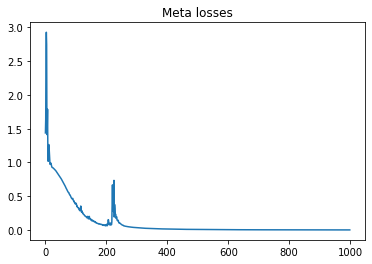

In [32]:
plt.plot(meta_losses)
plt.title("Meta losses")

In [33]:
# Use the trained models to make predictions on new data
test_preds = []
files = []

with torch.no_grad():
    for batch in test_dl:
        img, fname = batch
        model1_outputs = model1(img.to(device))
        model2_outputs = model2(img.to(device))
        meta_inputs = torch.cat((model1_outputs, model2_outputs), dim=1)
        meta_outputs = meta_model(meta_inputs)
        test_preds.extend(torch.argmax(meta_outputs, dim=1).detach().cpu())
        files.extend(np.array(fname).flatten())

        
df = pd.DataFrame({"Imagename":files, "preds":test_preds})
df.preds = df.preds.astype(int)
df.Imagename = df.Imagename.apply(lambda x: x.split("/")[-1])
df.to_csv("submission.csv", header=None, index=None)
pd.read_csv("submission.csv")

,20200724_094356_LH_C2_PN_M.jpg,0
0,20200724_094157_LF_C2_PN_M.jpg,0
1,20200724_094108_RF_C1_PN_M.jpg,0
2,20200724_093930_LH_C3_PN_M.jpg,1
3,20200724_094337_RF_C1_PN_M.jpg,0
4,20200724_094337_LH_C1_PN_M.jpg,0
...,...,...
374,R8_0736_45_crop_RF_C4_PN_m.jpg,2
375,R8_0726_35_crop_LH_C2_PN_m.jpg,1
376,R7_0692_48_crop_LH_C2_PN_m.jpg,1
377,R9_0793_57_crop_LH_C2_PP_m.jpg,1


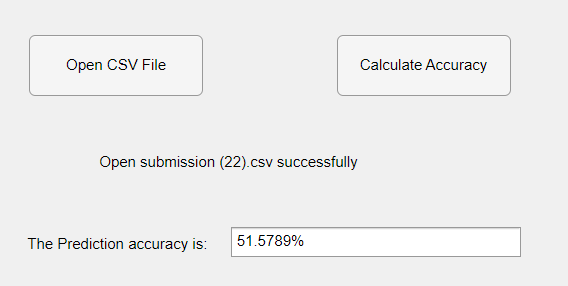